## `trfermikit` versus `manta`
For each tool, I asked: 
* how many of the pacbio calls did the tool recover (TP) 
* how many calls did the tool make that didn't overlap a pacbio call (FP) 
* how many pacbio calls were missed by the tool (FN)

In [4]:
import json

def add_performance(table, truvari_data, tool, calls):
    table.append([
            tool,
            calls,
            truvari_data['TP-base'],
            truvari_data['FN'],
            truvari_data['FP'], 
            truvari_data['TP-base'] + truvari_data['FN']
    ])
    
def create_performance_table(regions):
    table = []
    with open('{}/{}/truvari-pacbio-manta-{}/summary.txt'.format(directory, job, regions)) as json_file:
        add_performance(table, json.load(json_file), 'manta', 'all')    
    with open('{}/{}/truvari-pacbio-fermi.raw-{}/summary.txt'.format(directory, job, regions)) as json_file:
        add_performance(table, json.load(json_file), 'tr-fermikit', 'all')
    with open('{}/{}/truvari-pacbio-fermi.raw-{}.unitigSupport/summary.txt'.format(directory, job, regions)) as json_file:
        add_performance(table, json.load(json_file), 'tr-fermikit', 'unitigSupport')
    with open('{}/{}/truvari-pacbio-fermi.raw-{}.unitigSupport.thinned/summary.txt'.format(directory, job, regions)) as json_file:
        add_performance(table, json.load(json_file), 'tr-fermikit', 'unitigSupport.thinned')
    return table 

def extract_value(df, calls, truvari_class):
    return df[df['calls'] == calls][truvari_class].values[0]

def total_TP_count(df, calls_1, calls_2):
    return extract_value(df, calls_1, 'TP') + extract_value(df, calls_2, 'TP')

def total_FP_count(df, calls_1, calls_2):
    return extract_value(df, calls_1, 'FP') + extract_value(df, calls_2, 'FP')

def sum_counts(df, columns, calls_1, calls_2): 
    return pd.DataFrame([[
        'tr-fermikit', 
        '{} + {}'.format(calls_1, calls_2), 
        total_TP_count(df, calls_1, calls_2), 
        '.', 
        total_FP_count(df, calls_1, calls_2), 
        '.'
    ]], columns=columns)
    
def visualize_performance_table(regions):
    from IPython.display import HTML
    columns = ['tool', 'calls', 'TP', 'FN', 'FP', '# real events']
    df_ = pd.DataFrame(
        create_performance_table(regions), 
        columns=columns
    )
    return HTML(df_.to_html(index=False))
    
visualize_performance_table('regions.slopped.coverage-filtered.length-filtered')

tool,calls,TP,FN,FP,# real events
manta,all,1174,3565,1113,4739
tr-fermikit,all,1859,2880,7063,4739
tr-fermikit,unitigSupport,1645,3094,2694,4739
tr-fermikit,unitigSupport.thinned,1537,3202,1812,4739


The table above reports poor performance of `manta` in tandem-repeat regions. This has been found by others; see panels B and C at https://www.nature.com/articles/s41467-019-11146-4/figures/2 

After filtering `tr-fermikit` calls (see table), `tr-fermikit` performs better than `manta` in the sense that `tr-fermikit`'s TP count is higher and its FP count is lower. 

[Technical Note: applying the cluster-thinning filter eliminates TPs primarily because there are clusters harboring more than one event, e.g., the pacbio contig is “fragmented”. ]

## `tr-fermikit` picks up a significant number of calls missed by `manta` 

`tr-fermikit` picks up the majority of `manta` TPs while also discovering a significant number of pacbio events that `manta` missed:  

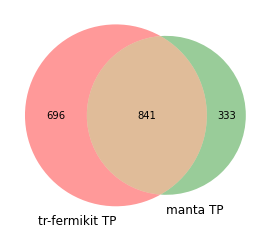

In [5]:
def list_to_value(list_): 
    value, = list_
    return int(value)

overlap_fraction = 0.9

def tr_fermikit_TP_intersect_manta(manta_callset): 
    list_ = ! bedtools intersect -u -wb -f $overlap_fraction -r \
      -a $directory/$job/truvari-pacbio-manta-regions.slopped.coverage-filtered.length-filtered/$manta_callset".vcf" \
      -b $directory/$job/truvari-pacbio-fermi.raw-regions.slopped.coverage-filtered.length-filtered.unitigSupport.thinned/tp-base.vcf \
      | wc -l 
    return list_to_value(list_)

def tr_fermikit_TP_less_manta(manta_callset):
    list_ = ! bedtools subtract -A -f $overlap_fraction -r \
      -a $directory/$job/truvari-pacbio-fermi.raw-regions.slopped.coverage-filtered.length-filtered.unitigSupport.thinned/tp-base.vcf \
      -b $directory/$job/truvari-pacbio-manta-regions.slopped.coverage-filtered.length-filtered/$manta_callset".vcf" \
      | wc -l
    return list_to_value(list_)

def manta_less_tr_fermikit_TP(manta_callset):
    list_ = ! bedtools subtract -A -f $overlap_fraction -r \
      -a $directory/$job/truvari-pacbio-manta-regions.slopped.coverage-filtered.length-filtered/$manta_callset".vcf" \
      -b $directory/$job/truvari-pacbio-fermi.raw-regions.slopped.coverage-filtered.length-filtered.unitigSupport.thinned/tp-base.vcf \
    | wc -l 
    return list_to_value(list_)

def check(manta_callset): 
    if manta_callset != 'fn' and manta_callset != 'tp-base': 
        raise Exception
    else: 
        pass
        
# https://towardsdatascience.com/how-to-create-and-beautify-venn-diagrams-in-python-331129bd4ed3
from matplotlib_venn import venn2

def tr_fermikit_manta_venn2(manta_callset, manta_label):
    check(manta_callset)
    vd = venn2(
        subsets = {
            '10': tr_fermikit_TP_less_manta(manta_callset),
            '11': tr_fermikit_TP_intersect_manta(manta_callset),
            '01': manta_less_tr_fermikit_TP(manta_callset)
        }, 
        set_labels = ('tr-fermikit TP', manta_label))
    return vd

_ = tr_fermikit_manta_venn2(manta_callset='tp-base', manta_label='manta TP')

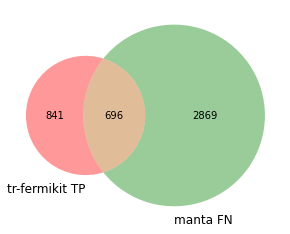

In [6]:
_ = tr_fermikit_manta_venn2(manta_callset='fn', manta_label='manta FN')